# Chapter 4. Geocentric Models

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import lax, random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import ELBO, SVI, Predictive, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

### Code 4.1

In [2]:
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)

### Code 4.2

In [3]:
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

DeviceArray(1.7294353, dtype=float32)

### Code 4.3

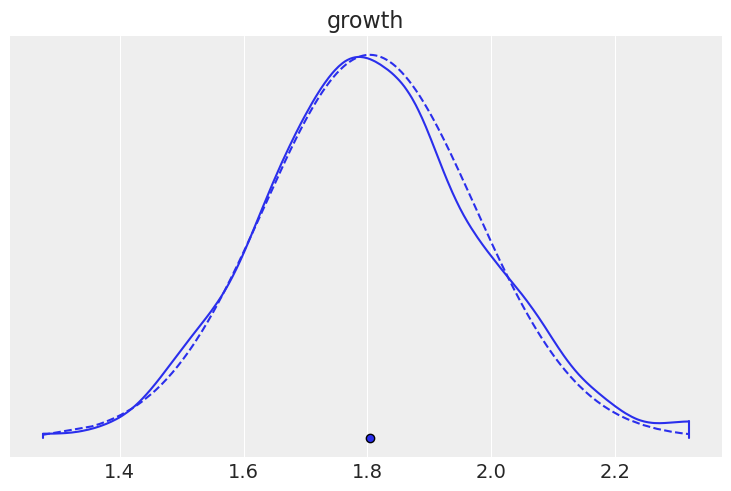

In [4]:
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12)), -1)
az.plot_density({"growth": growth}, hdi_prob=1)
x = jnp.sort(growth)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

### Code 4.4

In [5]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000, 12)), -1)

### Code 4.5

In [6]:
log_big = jnp.log(
    jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
)

### Code 4.6

In [7]:
w = 6
n = 9
p_grid = jnp.linspace(start=0, stop=1, num=100)
prob_binom = jnp.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * jnp.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior / jnp.sum(posterior)

### Code 4.7

In [8]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1

### Code 4.8

In [9]:
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.9

In [10]:
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



### Code 4.10

In [11]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11

In [12]:
d2 = d[d.age >= 18]

### Code 4.12

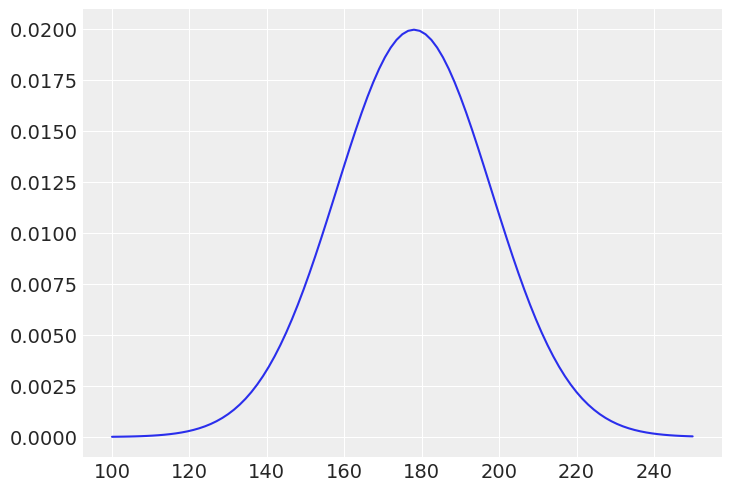

In [13]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()

### Code 4.13

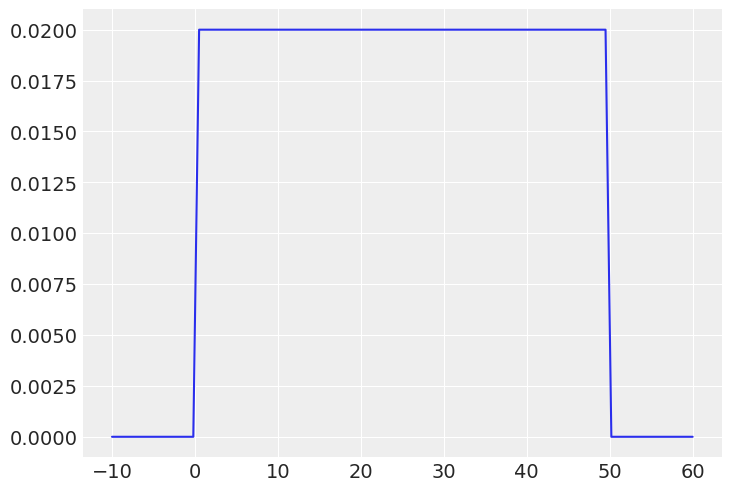

In [14]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))
plt.show()

### Code 4.14

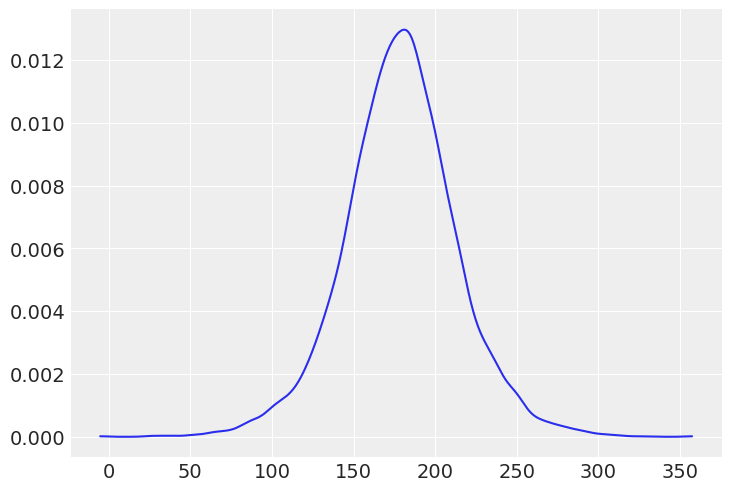

In [15]:
sample_mu = dist.Normal(178, 20).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

### Code 4.15

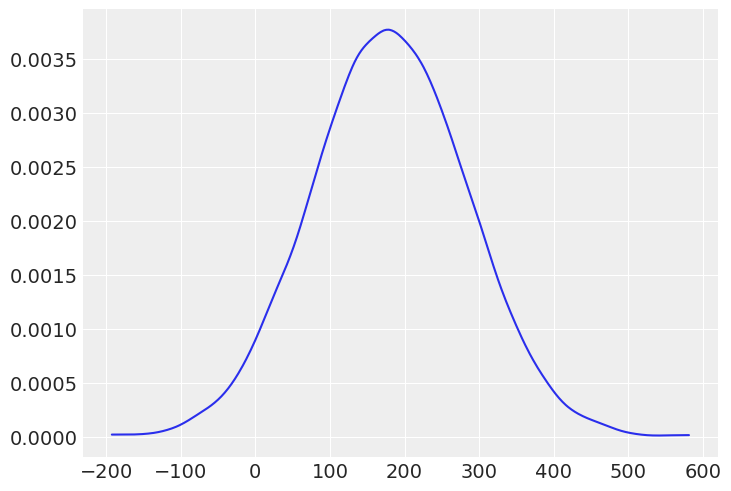

In [16]:
sample_mu = dist.Normal(178, 100).sample(random.PRNGKey(0), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

### Code 4.16

In [17]:
mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mesh = jnp.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values))
)(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

### Code 4.17

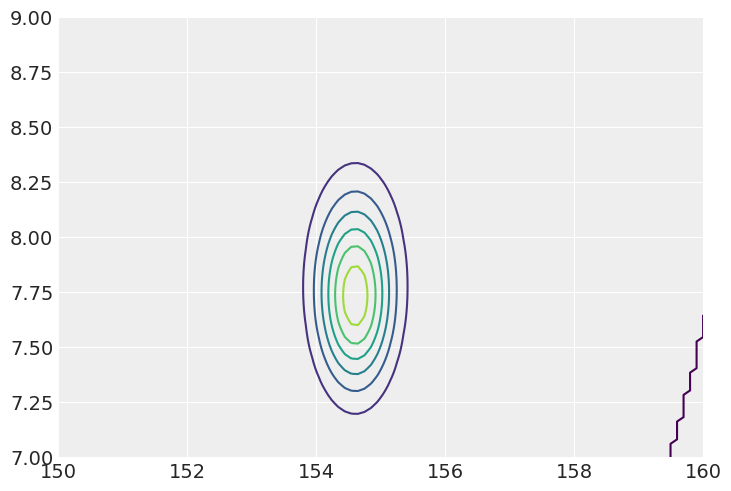

In [18]:
plt.contour(
    post["mu"].reshape(100, 100),
    post["sigma"].reshape(100, 100),
    post["prob"].reshape(100, 100),
)
plt.show()

### Code 4.18

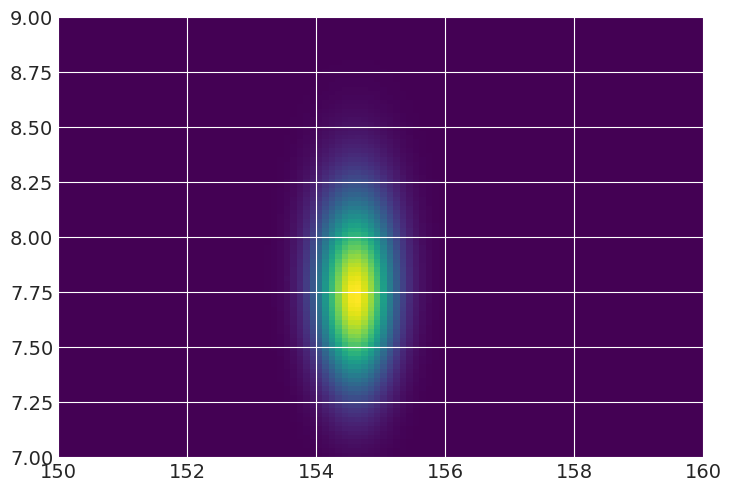

In [19]:
plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

### Code 4.19

In [20]:
prob = post["prob"] / jnp.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

### Code 4.20

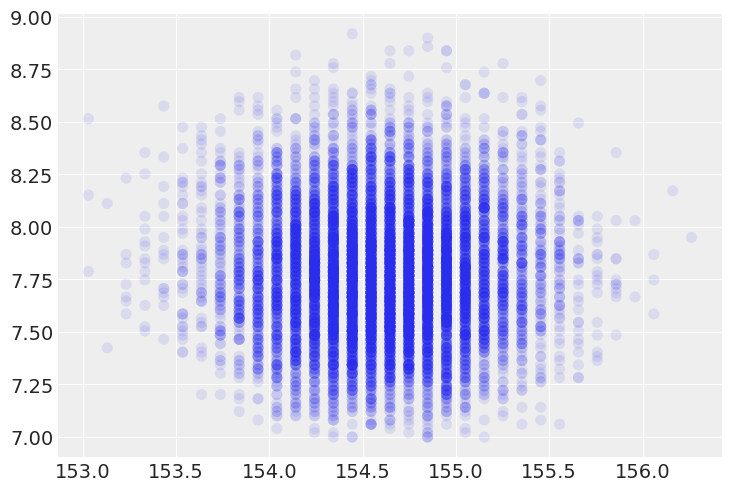

In [21]:
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

### Code 4.19

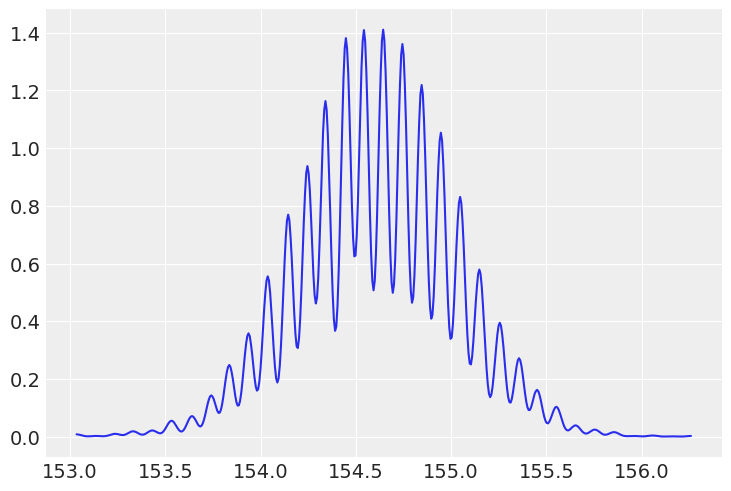

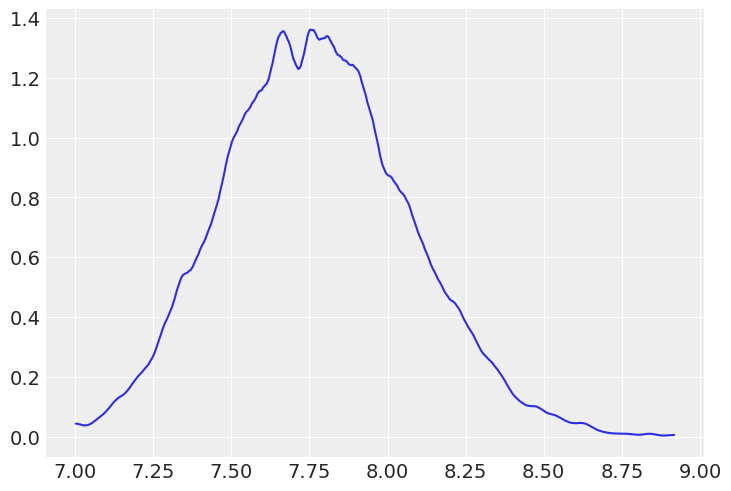

In [22]:
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma)
plt.show()

### Code 4.22

In [23]:
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


### Code 4.23

In [24]:
d3 = d2.height.sample(n=20)

### Code 4.24

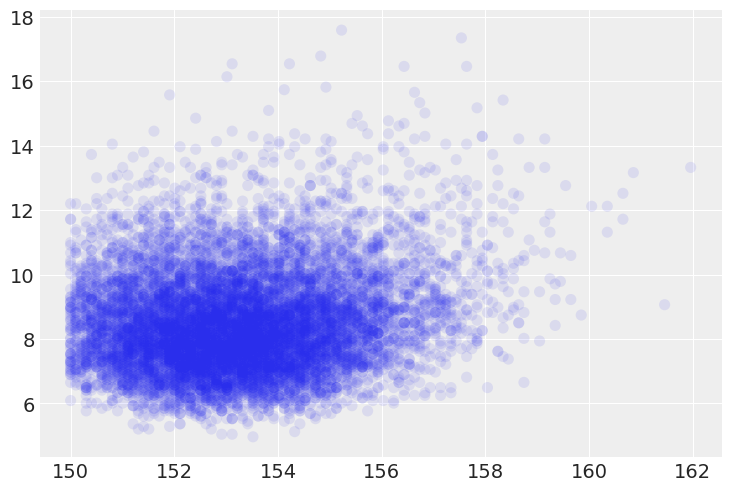

In [25]:
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

### Code 4.25

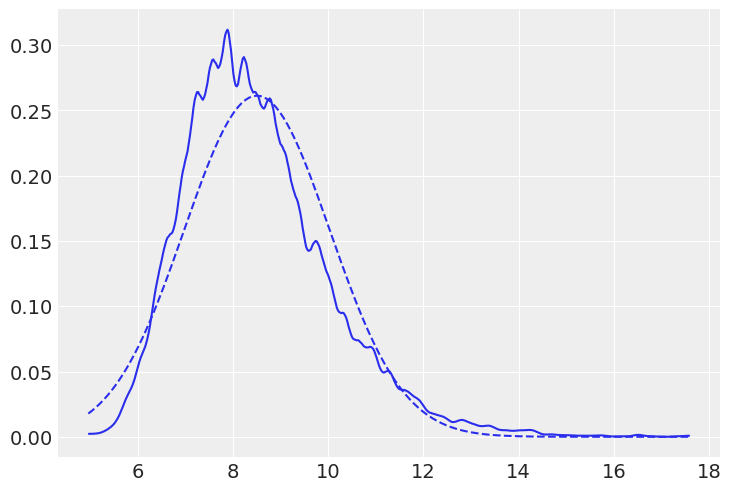

In [26]:
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

### Code 4.26

In [27]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

### Code 4.27

In [28]:
def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

### Code 4.28

In [29]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), ELBO(), height=d2.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p4_1 = svi.get_params(state)

**Note:** `lax.scan` is similar to `lax.fori_loop` but it also collects loss values at every steps. Instead of using `lax.scan`, we can use the native Python loop after jitting the SVI update method:
```python
from jax import jit

update_fn = jit(svi.update)
state = init_state
loss = []
for i in range(1000):
    state, loss_i = update_fn(state)
    loss.append(loss_i)
```
Using `lax.scan` is a bit faster though.

### Code 4.29

In [30]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.06      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



### Code 4.30

In [31]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist) #CA
#m4_1 = AutoLaplaceApproximation(flist, init_strategy=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), ELBO(), height=d2.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p4_1 = svi.get_params(state)

### Code 4.31

In [32]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), ELBO(), height=d2.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p4_2 = svi.get_params(state)
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



### Code 4.32

In [33]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
vcov

DeviceArray([[0.16253103, 0.00285712],
             [0.00285712, 0.08737663]], dtype=float32)

### Code 4.33

In [34]:
print(jnp.diagonal(vcov))
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

[0.16253103 0.08737663]
[[1.         0.02397521]
 [0.02397521 1.        ]]


### Code 4.34

In [35]:
post = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [154.29782, 154.53899, 155.03278, 154.26596, 155.54509, 154.8806],
 'sigma': [7.557641, 7.3057547, 7.2827177, 7.8088813, 7.911726, 7.980075]}

### Code 4.35

In [36]:
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.66      0.41    154.66    153.99    155.30   9926.98      1.00
     sigma      7.75      0.29      7.74      7.28      8.22   9502.52      1.00



### Code 4.36

In [37]:
samples_flat = jnp.stack(list(post.values()))
mu, sigma = jnp.mean(samples_flat), jnp.cov(samples_flat)
post = dist.MultivariateNormal(mu, sigma).sample(random.PRNGKey(0), (int(1e4),))

### Code 4.37

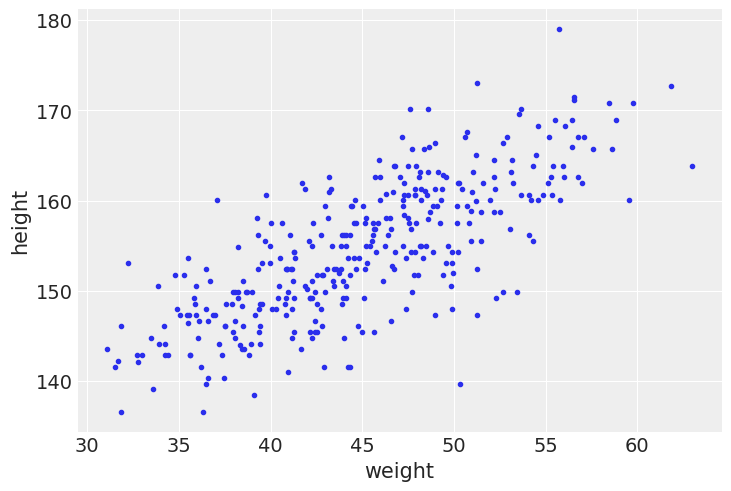

In [38]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
plt.show()

### Code 4.38

In [39]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([N]))

### Code 4.39

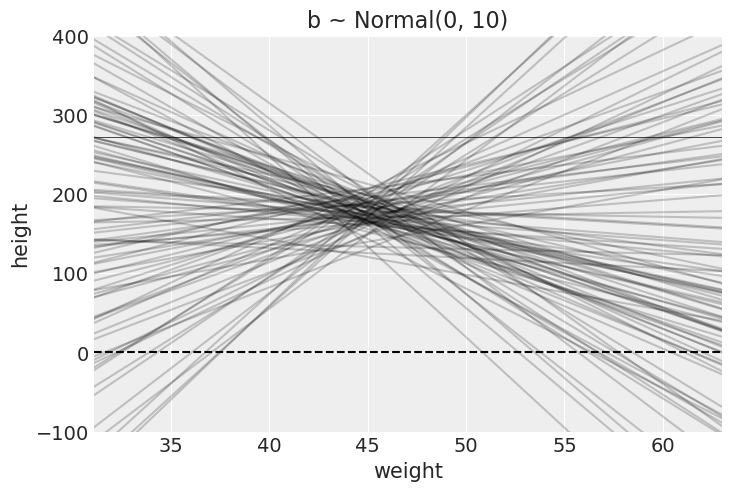

In [40]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

### Code 4.40

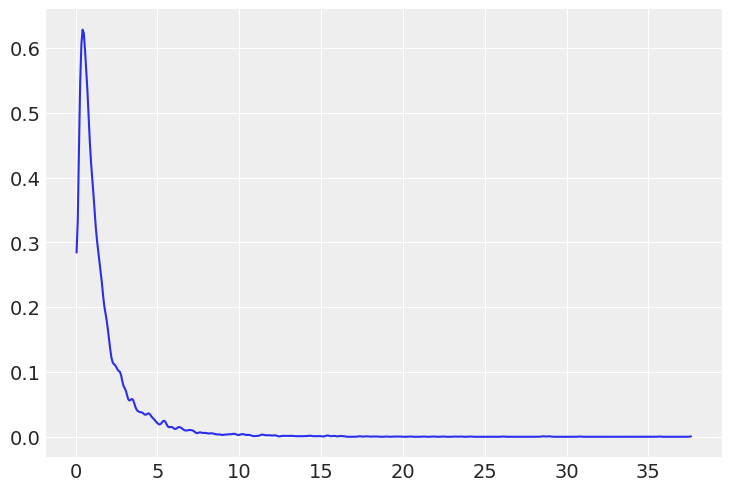

In [41]:
b = dist.LogNormal(0, 1).sample(random.PRNGKey(0), (int(1e4),))
az.plot_kde(b)
plt.show()

### Code 4.41

In [42]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 28).expand([N]))
    b = numpyro.sample("b", dist.LogNormal(0, 1).expand([N]))

### Code 4.42

In [43]:
# load data again, since it's a long way back
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m4_3, optim.Adam(1), ELBO(), weight=d2.weight.values, height=d2.height.values
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p4_3 = svi.get_params(state)

### Code 4.43

In [44]:
def model(weight, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    log_b = numpyro.sample("log_b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + jnp.exp(log_b) * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3b = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3b,
    optim.Adam(1),
    ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p4_3b = svi.get_params(state)

### Code 4.44

In [45]:
samples = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.62      0.27    154.63    154.16    155.03    931.50      1.00
         b      0.91      0.04      0.90      0.84      0.97   1083.74      1.00
     sigma      5.08      0.19      5.08      4.79      5.41    949.65      1.00



### Code 4.45

In [46]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 3)

DeviceArray([[0.075, 0.   , 0.001],
             [0.   , 0.002, 0.   ],
             [0.001, 0.   , 0.038]], dtype=float32)

### Code 4.46

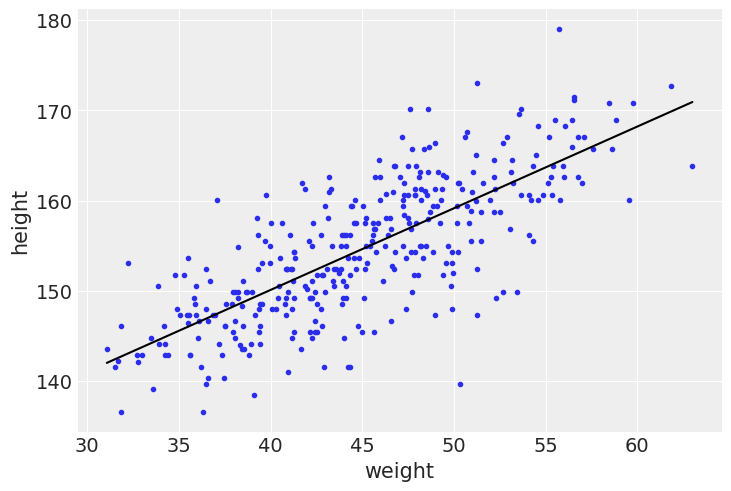

In [47]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k")
plt.show()

### Code 4.47

In [48]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
{latent: list(post[latent].reshape(-1)[:5]) for latent in post}

{'a': [154.36615, 154.78511, 154.73534, 154.53842, 154.53549],
 'b': [0.974645, 0.8900049, 0.81902206, 0.8334104, 1.0119178],
 'mu': [157.12938, 146.0771, 141.5733, 162.21344, 150.74669],
 'sigma': [4.976459, 4.943529, 5.2826033, 4.877721, 4.894869]}

### Code 4.48

In [49]:
N = 10
dN = d2[:N]


def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - jnp.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


mN = AutoLaplaceApproximation(model)
svi = SVI(
    model, mN, optim.Adam(1), ELBO(), weight=dN.weight.values, height=dN.height.values
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
pN = svi.get_params(state)

### Code 4.49

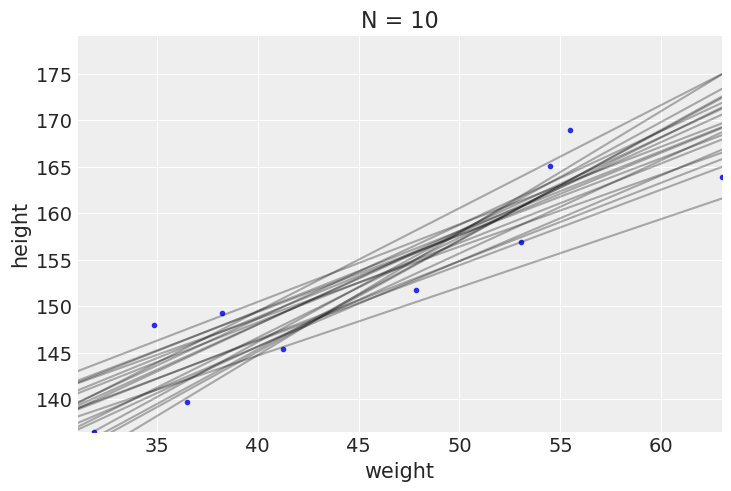

In [50]:
# extract 20 samples from the posterior
post = mN.sample_posterior(random.PRNGKey(1), pN, (20,))

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(d2.height.min(), d2.height.max()),
    title="N = {}".format(N),
)

# plot the lines, with transparency
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()), "k", alpha=0.3)

### Code 4.50

In [51]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_at_50 = post["a"] + post["b"] * (50 - xbar)

### Code 4.51

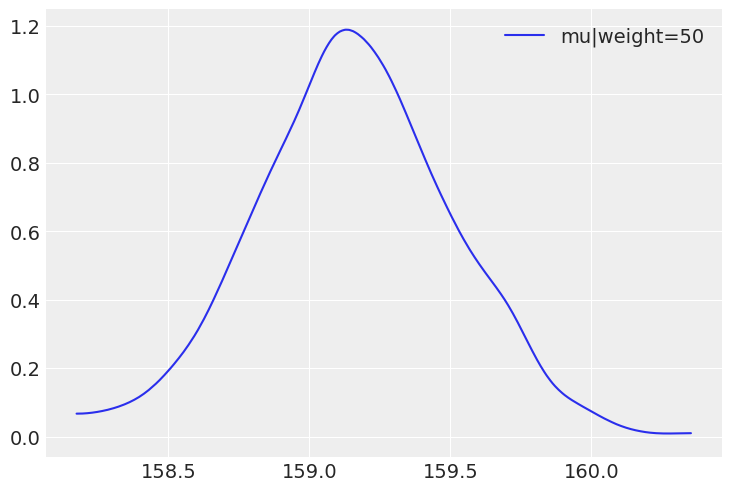

In [52]:
az.plot_kde(mu_at_50, label="mu|weight=50")
plt.show()

### Code 4.52

In [53]:
jnp.percentile(mu_at_50, q=(5.5, 94.5))

DeviceArray([158.5957 , 159.71445], dtype=float32)

### Code 4.53

In [54]:
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), d2.weight.values, d2.height.values
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 352), [157.12938, 157.30838, 157.05736, 156.90125, 157.4044])

### Code 4.54

In [55]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = jnp.arange(start=25, stop=71, step=1)

# use predictive to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 46), [134.88252, 136.99348, 138.36269, 137.87814, 134.30676])

### Code 4.55

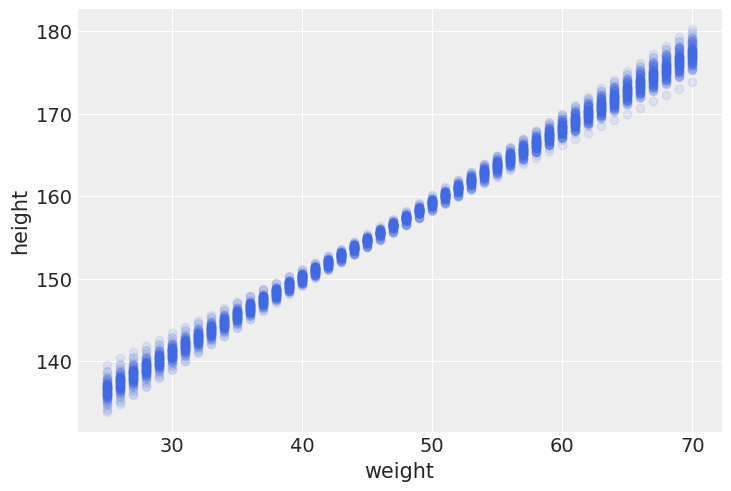

In [56]:
# use scatter_kwargs={"alpha": 0} to hide raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0}
)

# loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)

### Code 4.56

In [57]:
# summarize the distribution of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)

### Code 4.57

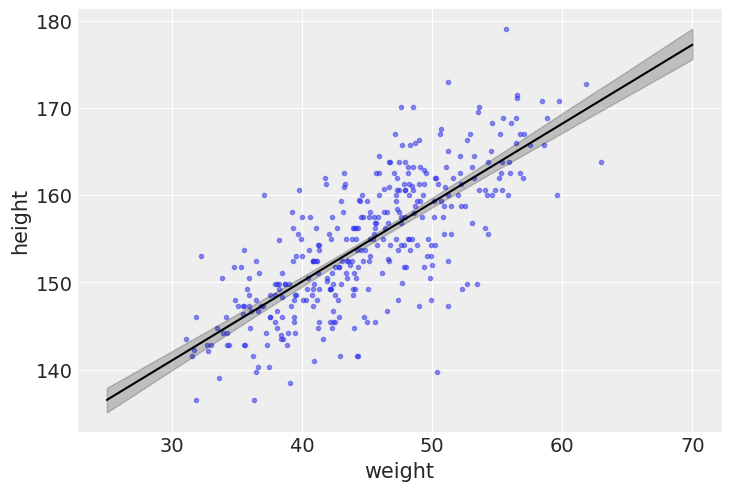

In [58]:
# plot raw data
# fading out points to make line and interval more visible
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")

# plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

### Code 4.58

In [59]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight - xbar)
weight_seq = jnp.arange(start=25, stop=71, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

### Code 4.59

In [60]:
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
sim_height.shape, list(sim_height[:5, 0])

((1000, 46), [135.85771, 137.52162, 133.89777, 138.14607, 131.1664])

### Code 4.60

In [61]:
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.61

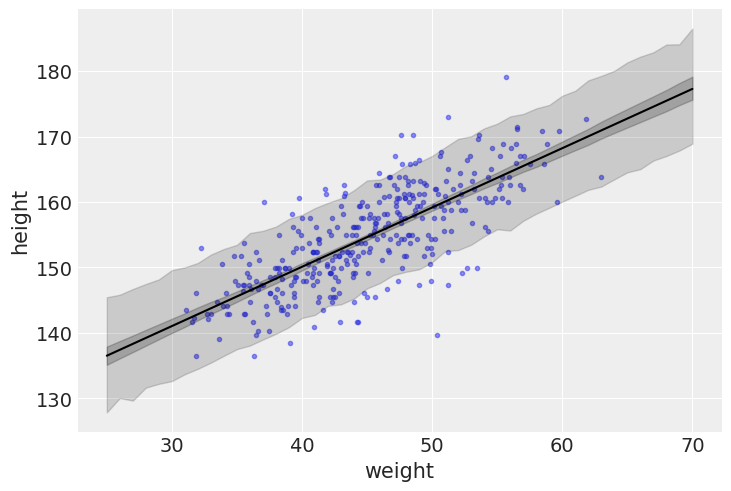

In [62]:
# plot raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

### Code 4.62

In [63]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, sample_shape=(int(1e4),))
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.63

In [64]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
weight_seq = jnp.arange(25, 71)
sim_height = vmap(
    lambda i, weight: dist.Normal(post["a"] + post["b"] * (weight - xbar)).sample(
        random.PRNGKey(i)
    )
)(jnp.arange(len(weight_seq)), weight_seq)
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.64

In [65]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.65

In [66]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s ** 2


def model(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_5,
    optim.Adam(0.3),
    ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    height=d.height.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_5 = svi.get_params(state)

### Code 4.66

In [67]:
samples = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
print_summary({k: v for k, v in samples.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     92.46      0.00     92.46     92.46     92.46       nan       nan
        b1     29.38      0.00     29.38     29.38     29.38      0.50      1.00
        b2      7.22      0.00      7.22      7.22      7.22      0.50      1.00
     sigma     49.02      0.00     49.02     49.02     49.02      0.50       nan



### Code 4.67

In [68]:
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq ** 2}
post = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
predictive = Predictive(m4_5.model, post)
mu = predictive(random.PRNGKey(2), **pred_dat)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.68

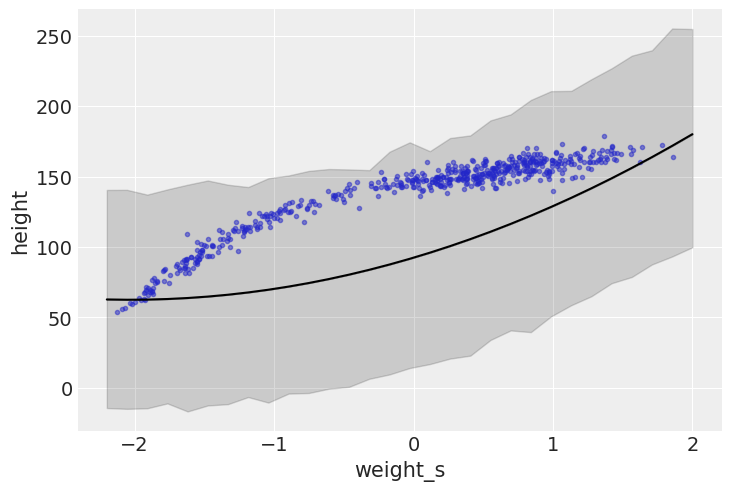

In [69]:
az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

### Code 4.69

In [70]:
d["weight_s3"] = d.weight_s ** 3


def model(weight_s, weight_s2, weight_s3, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_6 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_6,
    optim.Adam(0.3),
    ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    weight_s3=d.weight_s3.values,
    height=d.height.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_6 = svi.get_params(state)

### Code 4.70

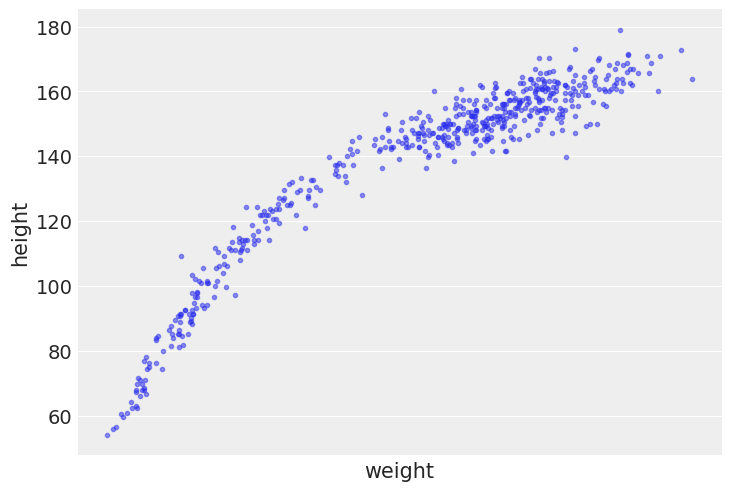

In [71]:
ax = az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
ax.set(xlabel="weight", ylabel="height", xticks=[])
fig = plt.gcf()

### Code 4.71

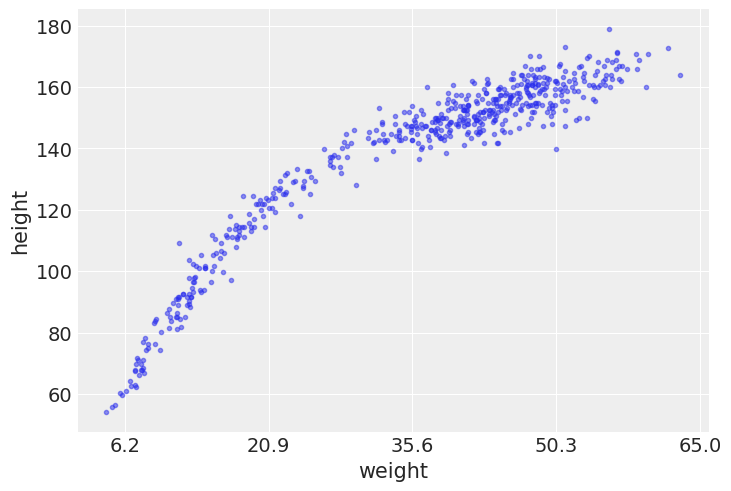

In [72]:
at = jnp.array([-2, -1, 0, 1, 2])
labels = at * d.weight.std() + d.weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label, 1) for label in labels])
fig

### Code 4.72

In [73]:
cherry_blossoms = pd.read_csv("../data/cherry_blossoms.csv", sep=";")
d = cherry_blossoms
print_summary({"year": d.year.dropna().values}, 0.89, False)
print_summary({"doy": d.doy.dropna().values}, 0.89, False)
print_summary({"temp": d.temp.dropna().values}, 0.89, False)
print_summary({"temp_upper": d.temp_upper.dropna().values}, 0.89, False)
print_summary({"temp_lower": d.temp_lower.dropna().values}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      year   1408.00    350.88   1408.00    801.00   1882.00      2.51      2.65


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       doy    104.54      6.41    105.00     93.00    113.00    111.98      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      temp      6.14      0.66      6.10      5.03      7.13     22.07      1.02


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_upper      7.19      0.99      7.04      5.66      8.54     10.11      1.24


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_lower      5.10      0.85      5.14      3.79      6.37     21.90      1.11



### Code 4.73

In [74]:
d2 = d[d.doy.notna()]  # complete cases on doy
num_knots = 15
knot_list = jnp.quantile(
    d2.year.values.astype(float), q=jnp.linspace(0, 1, num=num_knots)
)

### Code 4.74

In [75]:
knots = jnp.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, jnp.identity(num_knots + 2), k=3)(d2.year.values)

### Code 4.75

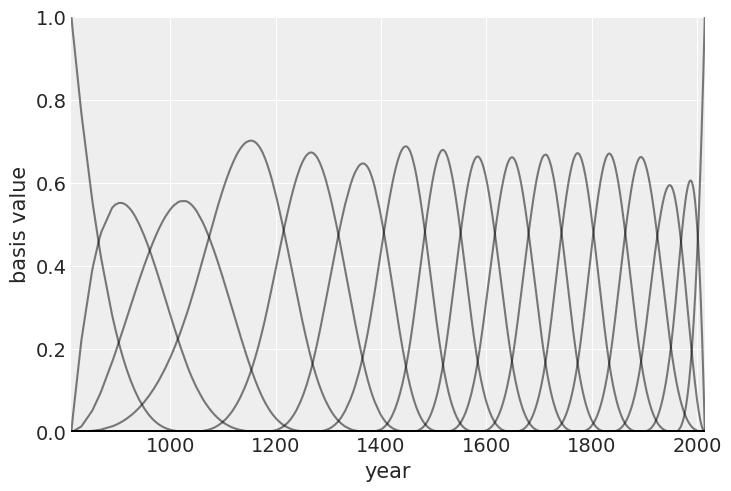

In [76]:
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(0, 1),
    xlabel="year",
    ylabel="basis value",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], "k", alpha=0.5)

### Code 4.76

In [77]:
def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model) #CA
#m4_7 = AutoLaplaceApproximation(model, init_strategy=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(0.3), ELBO(), B=B, D=d2.doy.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(10000))
p4_7 = svi.get_params(state)

### Code 4.77

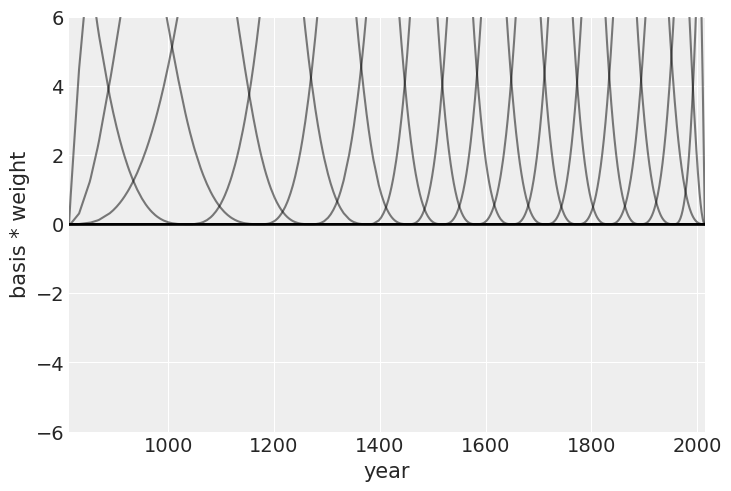

In [78]:
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000,))
w = jnp.mean(post["w"], 0)
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(-6, 6),
    xlabel="year",
    ylabel="basis * weight",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, (w[i] * B[:, i]), "k", alpha=0.5)

### Code 4.78

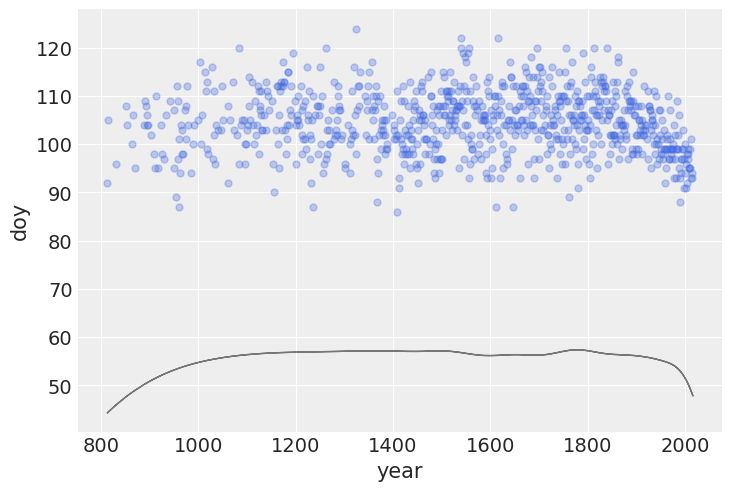

In [79]:
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=(1.5, 98.5), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"c": "royalblue", "alpha": 0.3, "markersize": 10},
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5)
plt.show()

### Code 4.79

In [80]:
def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + jnp.sum(B * w, axis=-1))
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4_7alt = AutoLaplaceApproximation(model) #CA
#m4_7alt = AutoLaplaceApproximation(model, init_strategy=init_to_value(values=start))
svi = SVI(model, m4_7alt, optim.Adam(0.3), ELBO(), B=B, D=d2.doy.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(10000))
p4_7alt = svi.get_params(state)